In [1]:
import tensorflow as tf
from tensorflow.python.keras import Input
from tensorflow.python.keras.engine.functional import Functional
from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.python.keras.models import Model

import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Lambda
import os


from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning, UpdatePruningStep, prune_low_magnitude

from callbacks import all_callbacks

from tensorflow.python.keras.regularizers import l2
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()

import tempfile
#from scipy.stats import norm

import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False


## Import the MNIST data class and call it.

Original dataset and modified dataset with modifiable resolution is shown below.

(60000, 64)


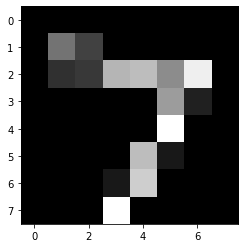

In [2]:
import MNIST_dataset as mnist
size_final = 8

data_zoom = mnist.MNISTData(size_final=size_final, color_depth=5)
test = data_zoom.x_test

plt.imshow(test[0].reshape(size_final,size_final), cmap='gray')
print(data_zoom.x_train.shape)

# Variational Autoencoder using Keras
The aim of this class is to implement the variational autoencoder and to test it on the MNIST dataset and then build a variational autoencoder that is able to classify MNIST data in its latent dimension with gaussian noise applied to the orignal images.

Code partially adapted from [Keras Documentation](https://keras.io/examples/generative/vae/).

In [3]:
class VAE:
    """Variational Autencoder Class"""
    def __init__(self, data: mnist.MNISTData, num_classes=10, pruned = False):
        
        self.x_train = data.x_train
        self.x_test = data.x_test
        self.y_train = data.y_train
        self.y_test = data.y_test

        self.num_classes = num_classes
        self.pruned = pruned
        self.input_shape = (self.x_train.shape[-1],)
        self.input = Input(shape=self.input_shape,name='encoder_input')
        self.latent_dim = 2
        self.latent_inputs=Input(shape=(self.latent_dim,), name='z_sampling')

        self.encoder = None
        self.encoder_model = None
        self.encoded_mean = None
        self.encoded_var = None

        self.latent_classifier = None

        self.decoder = None
        self.decoder_model=None

        self.VAE = None

        self.history = None

        self.pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.5, begin_step=200)}#, frequency=100)}
        
    def build_encoder(self):
        """Building the encoder architecture for the variational autoencoder. 
        The final encoding dimension is 2. 
        """
        self.encoder = Dense(32,  activation='relu')(self.input)
        
        if self.pruned:
            self.encoder = prune_low_magnitude(Dense(16,  activation='relu'), **self.pruning_params)(self.encoder) 
        
        if not self.pruned:
            self.encoder = Dense(16,  activation='relu')(self.encoder)  

        self.encoded_mean = Dense(self.latent_dim)(self.encoder)
        self.encoded_var = Dense(self.latent_dim)(self.encoder)
        self.encoder = Lambda(self.sampling, output_shape=(self.latent_dim,), name = 'encoder_output')([self.encoded_mean, self.encoded_var])

        #building a model for the encoder in order to be able to predict and plot the latent dimension
        self.encoder_model = Model(self.input, [self.encoded_mean, self.encoded_var, self.encoder], name='encoder')
        #self.encoder_model.summary()
    
    def build_decoder(self):
        """Building the decoder architecture and storing the output in self.decoder."""
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the decoder!")        

        if self.pruned:
            self.decoder = prune.prune_low_magnitude(Dense(16,  activation='relu'), **self.pruning_params)(self.latent_inputs)
            #self.decoder = prune_low_magnitude(Dense(16,  activation='relu'), **self.pruning_params)(self.encoder)
        if not self.pruned:
            self.decoder = Dense(16, activation='relu')(self.latent_inputs)
            #self.decoder = Dense(16, activation='relu')(self.encoder)
        
        self.decoder = Dense(32,activation='relu')(self.decoder)   
        self.decoder = Dense(self.input_shape[0], activation='sigmoid', name='decoder_output')(self.decoder)
        self.decoder_model = Model(self.latent_inputs, self.decoder, name='decoder')
        #self.decoder_model.summary()

    def build_classifier(self):
        """ Building the classifier architecture, using self.encoder as input."""
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the classifier!")
        
        if self.pruned:
            self.latent_classifier = prune.prune_low_magnitude(Dense(16,  activation='relu'), **self.pruning_params)(self.encoder)
        
        if not self.pruned:
            self.latent_classifier = Dense(16, activation='relu')(self.encoder)
            
        self.latent_classifier = Dense(32, activation='relu')(self.latent_classifier)
        self.latent_classifier = Dense(self.num_classes, activation='softmax',name='classifier_output')(self.latent_classifier)
        
    def build_vae(self, use_latent_classifier=False):
        """ Building the whole variational autoencoder Model from self.encoder and self.decoder with 
        self.input as input. It is used self.custom_loss as the model loss function.
        """
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the autoencoder!")
        if self.decoder is None:
            raise RuntimeError("The decoder has to be built before you can build the autoencoder!")
        
        self.dir()
        
        outputs=self.decoder_model(self.encoder_model(self.input)[2])
        
        if use_latent_classifier:
            if self.latent_classifier is None:
                raise RuntimeError("If you want to use the option with the latent classifier, you have to build it "
                                   "beforehand!")
            self.VAE = Model(self.input, outputs=[outputs, self.latent_classifier])
            self.VAE.compile(loss=self.custom_loss(self.encoded_mean, self.encoded_var), loss_weights=[1, 0.1], optimizer='adam', metrics=["accuracy"])
            if not self.pruned:
                self.VAE.save('model/VAE_model/KERAS_check_model_w_classifier.h5')
            if self.pruned:
                self.VAE.save('model/VAE_model/KERAS_check_pruned_model_w_classifier.h5')
        else:
            self.VAE = Model(self.input, outputs=outputs, name = 'VAE')
            #self.VAE = Model(self.input, outputs=self.decoder, name = 'VAE')

            self.VAE.compile(optimizer='adam', loss=self.custom_loss(self.encoded_mean, self.encoded_var))
            if not self.pruned:
                self.VAE.save('model/VAE_model/KERAS_check_model_wo_classifier.h5')
            if self.pruned:
                self.VAE.save('model/VAE_model/KERAS_check_pruned_model_wo_classifier.h5')

        self.VAE.summary()

    def sampling(self, args):
        """ Implement the Reparameterization trick. The function returns
         a vector randomly sampled from the latent space.
         # Arguments
        args (tensor): mean and log of variance of Q(z|X)
         # Returns
            z (tensor): sampled latent vector   
        """
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # we apply the multigaussian noise to every points at once
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    

    def custom_loss(self, mean, var):
        """Implement the loss function for the variational autoencoder.
        Sort of recepy for tf to how to compute loss function from two values."""
        
        def loss(y_true, y_pred):

            reconstruction_loss = tf.losses.mean_squared_error(y_true, y_pred)*784
            kl_loss = 1. + var - K.square(mean) - K.exp(var)
            kl_loss = K.sum(kl_loss, axis=-1)
            kl_loss *= -0.5
            beta = 1.0*10**-2
            return K.mean(reconstruction_loss + beta*kl_loss)

        return loss
        
        
    def fit_data(self, batch_size=256, epochs=20, use_latent_classifier=False):
        """Write the fit function for the autoencoder. 
        Store the fit history in self.history to be able to plot the fitting scores."""
        
        callbacks = all_callbacks(stop_patience = 1000,
                                    lr_factor = 0.5,
                                    lr_patience = 10,
                                    lr_epsilon = 0.000001,
                                    lr_cooldown = 2,
                                    lr_minimum = 0.0000001,
                                    outputDir = 'model/VAE_model/model_2')
        callbacks.callbacks.append(UpdatePruningStep()) 
        
                
        if use_latent_classifier:
            self.history = self.VAE.fit(self.x_train, [self.x_train, self.y_train],
                                                validation_data=(self.x_test, [self.x_test, self.y_test]),
                                                batch_size=batch_size, epochs=epochs,
                                                shuffle=True, callbacks=callbacks.callbacks)
            if not self.pruned:
                self.VAE.save_weights('model/VAE_model/KERAS_check_best_model_classifier.h5')
            if self.pruned:
                self.VAE = strip_pruning(self.VAE)
                self.VAE.save('model/VAE_model/KERAS_check_pruned_best_model_classifier.h5')
       
        else:

            self.history = self.VAE.fit(self.x_train, self.x_train,  
                                        validation_data=(self.x_test, self.x_test),
                                        batch_size=batch_size, epochs=epochs,
                                        shuffle=True, callbacks=callbacks.callbacks)
            if not self.pruned:
                self.VAE.save('model/VAE_model/KERAS_check_best_model.h5')
            if self.pruned:
                self.VAE = strip_pruning(self.VAE)
                self.VAE.save('model/VAE_model/KERAS_check_pruned_best_model.h5')

        self.history = self.history.history

    def dir(self):
        """Creation of the directories"""
        dir = os.path.join("images")
        if not os.path.exists(dir):
            os.mkdir(dir)
        dir2 = os.path.join("./images/VAE")
        if not os.path.exists(dir2):
            os.mkdir(dir2)
        dir3 = os.path.join("model")
        if not os.path.exists(dir3):
            os.mkdir(dir3)
        dir4 = os.path.join("./model/VAE_model")
        if not os.path.exists(dir4):
            os.mkdir(dir4)
    
    def plot_score(self, model_name=None, use_latent_classifier = False):
        """Plots the scores achieved during the fitting."""
        if use_latent_classifier is False:
            plt.plot(self.history['loss'])
            plt.plot(self.history['val_loss'])
            plt.ylabel('Model Accuracy')
        else:
            plt.plot(self.history['classifier_output_accuracy'])
            plt.plot(self.history['val_classifier_output_accuracy'])
            plt.ylabel('Classifier Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='best')
        plt.title('Accuracy of {model_name}'.format(model_name=model_name))
        
        plt.savefig('./images/VAE/Accuracy of {model_name}.png'.format(model_name=model_name))
        
        plt.show()

    def plot_latent_dimension(self, model_name=None):
        """Plots the latent dimension of the autoencoder."""
        prediction = self.encoder_model.predict(self.x_test)
        fig = plt.figure(figsize=(10, 10))
        fig.patch.set_facecolor("white")
        plt.scatter(prediction[2][:, 0], prediction[2][:, 1], c=np.argmax(self.y_test, axis=1) , cmap="Set3")
        plt.colorbar()
        plt.title('Latent space {model_name}'.format(model_name=model_name))
        
        plt.savefig('./images/VAE/Latent dimension of {model_name}.png'.format(model_name=model_name))

        plt.show()  
    
    def plot_generated_digits(self):
        n = 9  # figure with 15x15 digits
        digit_size = int(np.sqrt(self.input_shape[0]))
        figure = np.zeros((digit_size * n, digit_size * n))
        # We will sample n points within [-9, 9] standard deviations
        grid_x = np.linspace(-9, 9, n)
        grid_y = np.linspace(-9, 9, n)
        

        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = np.array([[xi, yi]])
                #print(xi, '\n', yi)
                x_decoded = self.decoder_model.predict(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                        j * digit_size: (j + 1) * digit_size] = digit

        plt.figure(figsize=(10, 10))
        plt.imshow(figure, cmap = 'gray')
        plt.savefig('./images/VAE/generated image.png')

        plt.show()





Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64)]              0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 2676      
_________________________________________________________________
decoder (Functional)         (None, 64)                2704      
Total params: 5,380
Trainable params: 5,380
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
51712/60000 [========================>.....] - ETA: 0s - loss: 98.0826 
***callbacks***
saving losses to model/VAE_model/model_2\losses.log

Epoch 00001: val_loss improved from inf to 68.73732, saving model to model/VAE_model/model_2\KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 68.73732, saving model to m

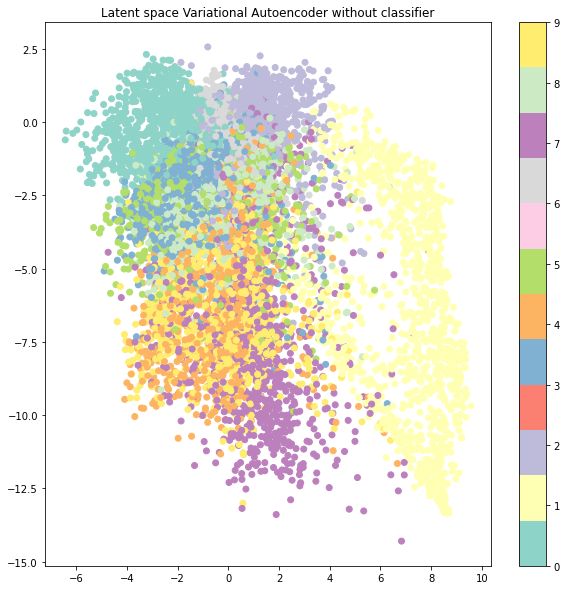

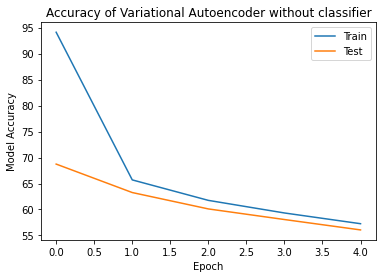

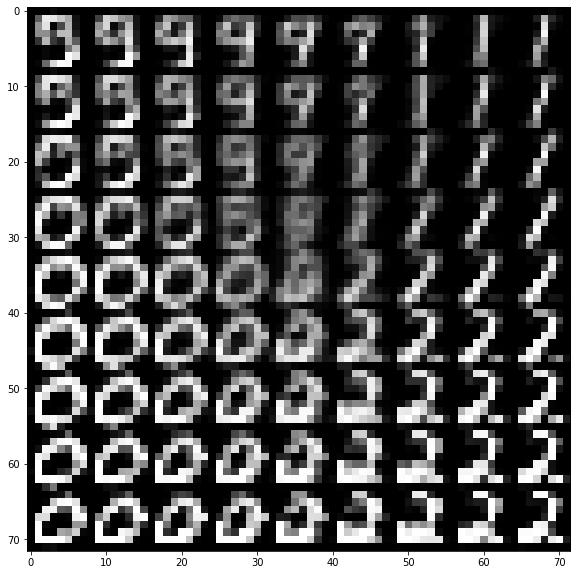

In [4]:
network = VAE(data_zoom, pruned=False)
network.build_encoder()
network.build_decoder()
network.build_vae(use_latent_classifier=False)
network.fit_data(epochs=5)
network.plot_latent_dimension("Variational Autoencoder without classifier")
network.plot_score(use_latent_classifier = False,model_name="Variational Autoencoder without classifier")
network.plot_generated_digits()


In [24]:
network_pruned = VAE(data_zoom, pruned=True)
network_pruned.build_encoder()
network_pruned.build_decoder()
network_pruned.build_vae()
network_pruned.fit_data(epochs=3, use_latent_classifier=False)
#network_pruned.plot_latent_dimension("Compressed VAE without classifier")
#network_pruned.plot_score(use_latent_classifier=False,model_name="Compressed VAE without classifier")

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64)]              0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 2676      
_________________________________________________________________
decoder (Functional)         (None, 64)                2738      
Total params: 5,414
Trainable params: 5,380
Non-trainable params: 34
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/3


InvalidArgumentError: assertion failed: [Prune() wrapper requires the UpdatePruningStep callback to be provided during training. Please add it as a callback to your model.fit call.] [Condition x >= y did not hold element-wise:] [x (assert_greater_equal/ReadVariableOp:0) = ] [-1] [y (assert_greater_equal/y:0) = ] [1]
	 [[{{node Assert}}]]

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64)]         0                                            
__________________________________________________________________________________________________
dense_38 (Dense)                (None, 32)           2080        encoder_input[0][0]              
__________________________________________________________________________________________________
dense_39 (Dense)                (None, 16)           528         dense_38[0][0]                   
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 2)            34          dense_39[0][0]                   
_______________________________________________________________________________________

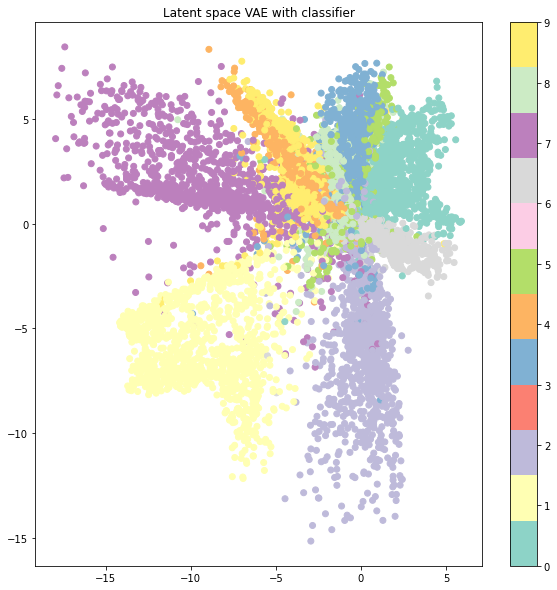

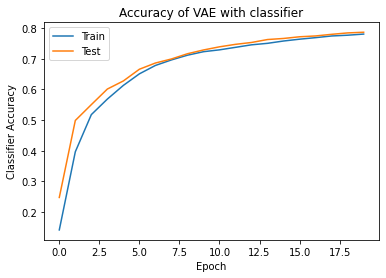

In [14]:
network_with_classifier = VAE(data_zoom, pruned=False)
network_with_classifier.build_encoder()
network_with_classifier.build_decoder()
network_with_classifier.build_classifier()
network_with_classifier.build_vae(use_latent_classifier=True)
network_with_classifier.fit_data(use_latent_classifier=True)
network_with_classifier.plot_latent_dimension("VAE with classifier")
network_with_classifier.plot_score(use_latent_classifier=True,model_name="VAE with classifier")


In [16]:
network_with_classifier = VAE(data_zoom, pruned=True)
network_with_classifier.build_encoder()
network_with_classifier.build_decoder()
network_with_classifier.build_classifier()
network_with_classifier.build_vae(use_latent_classifier=True)
network_with_classifier.fit_data(use_latent_classifier=True)
network_with_classifier.plot_latent_dimension("compressed VAE with classifier")
network_with_classifier.plot_score(use_latent_classifier=True,model_name="compressed VAE with classifier")


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64)]         0                                            
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 32)           2080        encoder_input[0][0]              
__________________________________________________________________________________________________
prune_low_magnitude_dense_53 (P (None, 16)           1042        dense_52[0][0]                   
__________________________________________________________________________________________________
dense_54 (Dense)                (None, 2)            34          prune_low_magnitude_dense_53[0][0
_______________________________________________________________________________________

InvalidArgumentError: assertion failed: [Prune() wrapper requires the UpdatePruningStep callback to be provided during training. Please add it as a callback to your model.fit call.] [Condition x >= y did not hold element-wise:] [x (assert_greater_equal/ReadVariableOp:0) = ] [-1] [y (assert_greater_equal/y:0) = ] [1]
	 [[{{node Assert}}]]